In this Assignment 2, I reused previous models and vectorizers, and applied an improved preprocessing method to perform grid search and implement model pipelines. I conducted a GridSearchCV on both the SVM and Decision Tree classifiers using the TF-IDF vectorizer to identify the best-performing parameters, as outlined in the assignment instructions. To reduce computation time, I limited the number of parameters in the grid search.

I implemented both k-Fold and Stratified k-Fold cross-validation methods and compared their results. Using the optimal parameters found, I built improved pipelines for SVM and Decision Tree models with the TF-IDF vectorizer. I then preprocessed and predicted the labels of the test dataset provided for the assigment using the SVM model, and generated a prediction output file for submission.

To evaluate performance, I measured accuracy, precision, recall, F1-score (both macro and weighted), confusion matrix, and ROC-AUC score on the test data split from the training set. I compared both models by compiling all metrics into a single DataFrame and plotting the ROC curves. The SVM model outperformed the Decision Tree in all key metrics.

Additionally, I created DataFrames for each model pipeline that include the original essay texts, true labels (0 = human, 1 = AI), and predicted labels. These DataFrames helped visualize and identify misclassified examples.

In [71]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import math
import time

# Sklearn libraries for machine learning and text processing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm, datasets
from sklearn import tree
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedGroupKFold, cross_validate, validation_curve, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, RocCurveDisplay, precision_recall_curve

# NLTK libraries for text processing (lemmatization, stemming, stopwords, POS tagging)
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Set up visualization
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

# Download necessary NLTK resources for text processing
nltk.download('wordnet')  # WordNet for lemmatization
nltk.download('omw-1.4')  # Open Multilingual Wordnet
nltk.download('punkt')  # Tokenizer
nltk.download('punkt_tab')
nltk.download('stopwords')  # Stopwords for text cleaning
nltk.download('averaged_perceptron_tagger')  # POS tagger for part-of-speech tagging
nltk.download('tagsets_json')  # Tagset resource

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets_json to /root/nltk_data...
[nltk_data]   Package tagsets_json is already up-to-date!


True

1.  Data loading and exploration

In [32]:
ds_train = pd.read_excel('AI_vs_huam_train_dataset.xlsx')
ds_test = pd.read_csv('Final_test_data.csv')

In [4]:
#Display data
ds_train.head()

essay  label
0  International sports events require the most w...      0
1  Globalisation has become a significant aspect ...      0
2  There is an ever-increasing number of bullying...      0
3  It is commonly believed, that companies should...      0
4  Despite knowing about the adverse effects of c...      0

In [5]:
ds_train['essay']

0       International sports events require the most w...
1       Globalisation has become a significant aspect ...
2       There is an ever-increasing number of bullying...
3       It is commonly believed, that companies should...
4       Despite knowing about the adverse effects of c...
                              ...                        
3723    I agree that successful people are willing to ...
3724    I believe that people who are open to trying n...
3725    To succeed in life, we must do everything poss...
3726    I'm not entirely sure what the word "successfu...
3727    The key to success is trying new things while ...
Name: essay, Length: 3728, dtype: object

In [6]:
ds_train.describe()

label
count  3728.000000
mean      0.500000
std       0.500067
min       0.000000
25%       0.000000
50%       0.500000
75%       1.000000
max       1.000000

2.  Text preprocessing functions:
remove stopword
lowercase
remove punc
stemming/limmatatization

2- Processing functions


peprocessing using lemmatizer

In [6]:
class text_processing:

  def __init__(self):
    self.lemmatizer = WordNetLemmatizer()
    self.STOPWORDS = set(stopwords.words('english'))
    self.STOPWORDS.update(['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])



  def text_cleaning_and_normalization(self, essay):

    # Handle non-string values
    if not isinstance(essay, str):
        return ""
    #convert to lowercase
    essay = essay.lower()
    #remove numerical value and alphanumeric tokens
    essay = re.sub(r'\w*\d\w*', '', essay) #using re pattern
    #remove punnc
    nopunc = ''.join([char for char in essay if char not in string.punctuation])
    essay = ' '.join([word for word in nopunc.split() if word.lower() not in self.STOPWORDS])
    return essay
  #Lemmatization
  def lemmatization(self, essay):
    tokens = nltk.word_tokenize(essay)
    lemmetized_tokens = []
    for token in tokens:
      if token not in self.STOPWORDS:
        lemmetized_tokens.append(self.lemmatizer.lemmatize(token))
    return ' '.join(lemmetized_tokens)
  #preprocess
  def preprocess(self, essay):
    cleaned_essay = self.text_cleaning_and_normalization(essay)
    lemmatized_text = self.lemmatization(cleaned_essay)
    return lemmatized_text



In [34]:
#Apply text cleaning to the "essay" column
preprocessor = text_processing()
ds_train['clean_essay'] = ds_train['essay'].apply(preprocessor.preprocess).copy()
ds_test['clean_essay'] = ds_test['essay'].apply(preprocessor.preprocess) #train test datas so it is also familiar to those
ds_train.head()

essay  label  \
0  International sports events require the most w...      0   
1  Globalisation has become a significant aspect ...      0   
2  There is an ever-increasing number of bullying...      0   
3  It is commonly believed, that companies should...      0   
4  Despite knowing about the adverse effects of c...      0   

                                         clean_essay  
0  international sport event require welltrained ...  
1  globalisation become significant aspect world ...  
2  everincreasing number bullying activity numero...  
3  commonly believed company dress code policy em...  
4  despite knowing adverse effect climate change ...

How to compare vocabulary size before and after stop word removal?

In [8]:
# call vocabs
train_vocab_clean = set(" ".join(ds_train['clean_essay']).split())
train_vocab_notclean = set(" ".join(ds_train['essay']).split())
test_vocab_clean = set(" ".join(ds_test['clean_essay']).split())
test_vocab_notclean = set(" ".join(ds_test['essay']).split())


print("=== Vocabulary statistics ===")
print(f"Train vocab clean : {len(train_vocab_clean):,}")
print(f"trained vocab not clean : {len(train_vocab_notclean):,}")
print(f"Test vocab clean: {len(test_vocab_clean):,}")
print(f"Test vocab not clean: {len(test_vocab_notclean):,}")

=== Vocabulary statistics ===
Train vocab clean : 24,186
trained vocab not clean : 42,702
Test vocab clean: 9,753
Test vocab not clean: 16,261


In [9]:
#show examples of original words and processed versions
print("Sample train words clean :", sorted(list(train_vocab_clean))[:1000], "...\n")
print("Sample trained  words not clean :", sorted(list(train_vocab_notclean))[:1000], "...\n")


Sample train words clean : ['aa', 'aaaas', 'aalready', 'abandon', 'abandond', 'abandoned', 'abandoning', 'abandonned', 'abati', 'abati‚äôs', 'abbbandon', 'abbility', 'abbreviated', 'abbreviation', 'abceventhough', 'abd', 'abdicate', 'abdul', 'abdulazez', 'abdulaziz', 'abetter', 'abide', 'abilit', 'abilites', 'abilitie', 'abilitiesso', 'abilities‚äîall', 'abilities‚äîessentially', 'abilities‚äîsome', 'abilities‚äîwhat', 'abilitity', 'abilitiy', 'ability', 'abilityfinally', 'abilityit', 'abilitymotivation', 'abilityso', 'abillities', 'abillity', 'abilties', 'abiltities', 'abilty', 'abituee', 'able', 'ablities', 'ablity', 'ablr', 'abn', 'abnormal', 'aboard', 'abolish', 'abolished', 'abolishing', 'abolishment', 'abolition', 'abondoned', 'aboout', 'abortion', 'abot', 'abou', 'abound', 'aboutgrowth', 'abouthowever', 'aboutones', 'abouttaking', 'about‚äîcan', 'abovei', 'abovementioned', 'abovereviewed', 'abraham', 'abreast', 'abroad', 'abroad‚äîsuch', 'abroad‚äîthey‚äôll', 'abroad‚äù', 'abrup

2.  Feature extraction with pipeline integration

Define x and y values for stemmed essays

Define X and y values for lemmatized essays

In [10]:
X = ds_train['clean_essay']
y = ds_train['label']
print("X: \n", X)
print("\ny: \n", y)

X: 
 0       international sport event require welltrained ...
1       globalisation become significant aspect world ...
2       everincreasing number bullying activity numero...
3       commonly believed company dress code policy em...
4       despite knowing adverse effect climate change ...
                              ...                        
3723    agree successful people willing try new thing ...
3724    believe people open trying new thing willing t...
3725    succeed life must everything possible‚äîand so...
3726    entirely sure word successful really mean used...
3727    key success trying new thing minimizing risk t...
Name: clean_essay, Length: 3728, dtype: object

y: 
 0       0
1       0
2       0
3       0
4       0
       ..
3723    1
3724    1
3725    1
3726    1
3727    1
Name: label, Length: 3728, dtype: int64


Split Stemmed training data

In [11]:
#split training data into two parts (80% training dat and 20% test data)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Split Lemmatized traing data

Vectorization Technique

In [12]:
#TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    max_features=3728,        #limit vocab size to 3728
    binary=True,
    token_pattern=r'\b\w+\b', #pattern (includes words with 1 char + more)
    ngram_range=(1, 1), #minimum 1 max words 1
    max_df=0.9,         #Ignore terms appearing in more than 90% of documents
    min_df=2            #Ignore terms appearing in less than 2 documents
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
print(f"TF-IDF matrix shape: {X_train_tfidf.shape}")
print(f"\nVectorizer vocabulary size: {len(vectorizer.get_feature_names_out())}")
print(f"Sample features: {vectorizer.get_feature_names_out()}")
print(X_val_tfidf.toarray())

TF-IDF matrix shape: (2982, 3728)

Vectorizer vocabulary size: 3728
Sample features: ['abandon' 'ability' 'able' ... 'äúsuccess' 'äúsuccessful' 'äúthe']
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.10443406 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


3. Advanced Model Developent with GridSearchCV

Pipeline Creation

SVM pipeline setup

In [13]:
pipe_svm = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', svm.SVC())])       #pipeline with svc as classifier

Decision Tree pipeline setup

In [14]:
pipe_tree = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', tree.DecisionTreeClassifier())])#pipleine with decision tree as classifier

Hyperparameter Optimization

GridSearchCV implementation

In [39]:
#set parameters for tree and svm grid
#parameters for svm
svm_param_grid =  {
    "vectorizer__max_features":[2000, 3000],
    "vectorizer__ngram_range": [(1,2), (1,3)],
    "classifier__C": [1, 10, 100],
    "classifier__kernel": ["linear","rbf"],
    "classifier__gamma": ["scale", "auto", 0.001, 0.01]
  }
#parameters for tree
tree_param_grid =  {
    "vectorizer__max_features":[2000, 3000],
    "vectorizer__ngram_range":  [(1,2), (1,3)],
    "classifier__criterion": ['gini', 'entropy'],
    "classifier__max_depth": [None],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [2, 4]
  }

In [40]:
#create Grid search oblects
svm_grid_search = GridSearchCV(pipe_svm, svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1, return_train_score=True)
tree_grid_search = GridSearchCV(pipe_tree, tree_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1, return_train_score=True)

In [41]:
#Perform Grid search
X_tree_grid= tree_grid_search.fit(X_train, y_train)#Grid search for tree

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [42]:
X_svm_grid = svm_grid_search.fit(X_train, y_train)#Grid search for svm


Fitting 5 folds for each of 96 candidates, totalling 480 fits


Best parameter analysis

In [49]:
#Best parameter analysis
print(f"Best svm parameters: {svm_grid_search.best_params_}")
print(f"Best svm cross-validation score: {svm_grid_search.best_score_:.4f}")
print(f"Best tree parameters: {tree_grid_search.best_params_}")
print(f"Best tree cross-validation score: {tree_grid_search.best_score_:.4f}")


Best svm parameters: {'classifier__C': 100, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf', 'vectorizer__max_features': 2000, 'vectorizer__ngram_range': (1, 2)}
Best svm cross-validation score: 0.9762
Best tree parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'vectorizer__max_features': 2000, 'vectorizer__ngram_range': (1, 2)}
Best tree cross-validation score: 0.9145


Cross-Validation Analysis

k-fold Cross validation

In [18]:
# 5-fold cross validation for svm
print("Perform cross validation")
cv_results ={}
cv_scores_svm = cross_val_score(pipe_svm, X_train, y_train, cv=5, scoring='accuracy')
print(f"SVM cross-validation scores: {cv_scores_svm}")
print(f"Mean SVM cross-validation score: {cv_scores_svm.mean():.4f} (+/- {cv_scores_svm.std() *2:.4f})")

#5-fold cross validation for tree
cv_scores_tree = cross_val_score(pipe_tree, X_train, y_train, cv=5, scoring='accuracy')
print(f"Decision Tree cross-validation scores: {cv_scores_tree}")
print(f"Mean Decision Tree cross-validation score: {cv_scores_tree.mean():.4f} (+/- {cv_scores_tree.std() *2:.4f})")

Perform cross validation
SVM cross-validation scores: [0.95644891 0.96649916 0.95637584 0.94295302 0.94798658]
Mean SVM cross-validation score: 0.9541 (+/- 0.0162)
Decision Tree cross-validation scores: [0.91792295 0.91624791 0.90604027 0.89261745 0.8909396 ]
Mean Decision Tree cross-validation score: 0.9048 (+/- 0.0227)


Stratified K-fold implementation

In [16]:
#stratified k-fold implementation
print("Perform stratified k-fold cross validation")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

stratified_scores_svm = cross_val_score(pipe_svm, X_train, y_train, cv=skf, scoring='accuracy')
print(f"SVM cross-validation scores: {stratified_scores_svm}")
print(f"Mean SVM cross-validation score: {stratified_scores_svm.mean():.4f} (+/- {stratified_scores_svm.std() *2:.4f})")

stratified_scores_tree = cross_val_score(pipe_tree, X_train, y_train, cv=skf, scoring='accuracy')
print(f"Decision Tree cross-validation scores: {stratified_scores_tree}")
print(f"Mean Decision Tree cross-validation score: {stratified_scores_tree.mean():.4f} (+/- {stratified_scores_tree.std() *2:.4f})")

Perform stratified k-fold cross validation
SVM cross-validation scores: [0.95644891 0.96147404 0.95134228 0.96644295 0.95134228]
Mean SVM cross-validation score: 0.9574 (+/- 0.0118)
Decision Tree cross-validation scores: [0.9078727  0.90284757 0.91275168 0.90436242 0.88926174]
Mean Decision Tree cross-validation score: 0.9034 (+/- 0.0157)


Compare the two

In [19]:
#Compare stratified k-fold with regular k-fold
regular_mean = cv_scores_svm.mean()
regular_std = cv_scores_svm.std()
stratified_mean = stratified_scores_svm.mean()
stratified_std = stratified_scores_svm.std()
print(f"Regular k-fold cross-validation score: {regular_mean:.4f} (+/- {regular_std *2:.4f})")
print(f"Stratified k-fold cross-validation score: {stratified_mean:.4f} (+/- {stratified_std *2:.4f})")
print(f"Difference in scores: {abs(stratified_mean - regular_mean):.4f}")
#

Regular k-fold cross-validation score: 0.9541 (+/- 0.0162)
Stratified k-fold cross-validation score: 0.9574 (+/- 0.0118)
Difference in scores: 0.0034


Model Evaluation and Compatison

In [20]:
print("Multiple Scoring Metrics")

# Define valid scoring metrics (remove 'confusion matrix')
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Define models and names
models = [pipe_svm, pipe_tree]
model_names = ['SVM', 'Decision Tree']

# Initialize results dictionary
multi_score_results = {}

print("Detailed evaluation metrics:")
for model, name in zip(models, model_names):
    print(f"\n{name.upper()}:")
    multi_score_results[name] = {}
    for metric in scoring_metrics:
        scores = cross_validate(model, X_train, y_train, cv=skf, scoring=metric)
        mean_score = scores['test_score'].mean()
        std_score = scores['test_score'].std()
        multi_score_results[name][metric] = (mean_score, std_score)
        print(f"{metric.capitalize()}: {mean_score:.4f} (+/- {2*std_score:.4f})")



Multiple Scoring Metrics
Detailed evaluation metrics:

SVM:
Accuracy: 0.9574 (+/- 0.0118)
Precision: 0.9586 (+/- 0.0272)
Recall: 0.9564 (+/- 0.0153)
F1: 0.9574 (+/- 0.0112)
Roc_auc: 0.9927 (+/- 0.0040)

DECISION TREE:
Accuracy: 0.9051 (+/- 0.0140)
Precision: 0.9066 (+/- 0.0248)
Recall: 0.9101 (+/- 0.0302)
F1: 0.9073 (+/- 0.0170)
Roc_auc: 0.9071 (+/- 0.0242)


Implement pipeline with best parameters


In [61]:
#Pipeline final
pipe_svm_final = Pipeline([('vectorizer', TfidfVectorizer(max_features=2000, binary=True, ngram_range=(1,2))), ('classifier', svm.SVC(C=100, kernel='rbf', gamma=0.1, probability=True))])
pipe_tree_final = Pipeline([('vectorizer', TfidfVectorizer(max_features=2000, binary=True, ngram_range=(1,2))), ('classifier', tree.DecisionTreeClassifier(criterion='entropy', max_depth=None))])

pipe_svm_final.fit(X_train, y_train)
pipe_tree_final.fit(X_train, y_train)


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(binary=True, max_features=2000,
                                 ngram_range=(1, 2))),
                ('classifier', DecisionTreeClassifier(criterion='entropy'))])

Final Predictions and Results

In [52]:
#predict test datas using pipeline
print("Preprocessing datas...")
ds_test['clean_essay'] = ds_test['essay'].apply(preprocessor.preprocess)
print("Preprocessing done!")

print("predicting datas...")
test_prediction = pipe_svm_final.predict(ds_test['clean_essay'])
print("/n==========Predictions: ==========/n")
print(test_prediction)


Preprocessing datas...
Preprocessing done!
predicting datas...
/n==========Predictions: ==========/n
[0 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 0 1
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1 0
 1 1 0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 1
 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1
 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1
 1 0 0 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 1 1 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0
 0 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1
 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0
 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1

In [53]:
#pred values and creatrion of pred file
Prediction_df = pd.DataFrame({'essay': ds_test['essay'], 'label': test_prediction})

# Display the predicted labels
print("\nPredicted labels for test data:")
Prediction_df

#Create the prediction file
Prediction_df.to_csv('Prediction.csv', index=False)


Predicted labels for test data:


5. Evaluation and visualization

Evaluation Metrics Comparison Table

In [78]:
y_pred_svm = pipe_svm_final.predict(X_val)
y_pred_tree = pipe_tree_final.predict(X_val)

# Function to compute metrics
def evaluate_model(name, y_true, y_pred): #take model name, y_val, and y_pred as args
    return {                            #return dictionary with all metrics evaluation
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_pred)
    }
#compute metrics on svm and tree predictions
evaluation_results = [
    evaluate_model("SVM", y_val, y_pred_svm),
    evaluate_model("Decision Tree", y_val, y_pred_tree)
]
#create data evaluation results's frame
df_results = pd.DataFrame(evaluation_results)
print(df_results)

           Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0            SVM  0.981233   0.976127  0.986595  0.981333  0.981233
1  Decision Tree  0.926273   0.922872  0.930295  0.926569  0.926273


SVM performance is better than Decision Tree. It has higher performing metrics than Decision Tree's in every category.

ROC curve

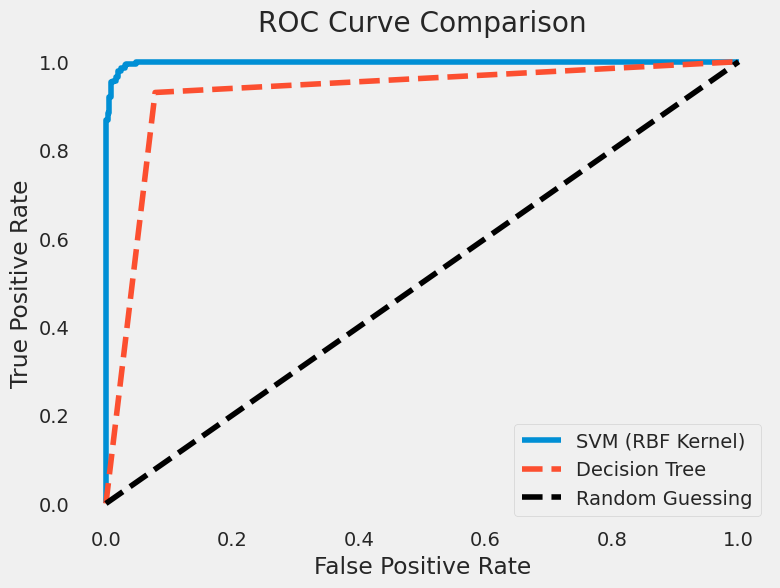

In [65]:
# Get decision function for SVM (after fitting with probability=True)
y_score_svm = pipe_svm_final.predict_proba(X_val)[:, 1]

# Get probabilities from decision tree
y_score_tree = pipe_tree_final.predict_proba(X_val)[:, 1]

# Compute ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_val, y_score_svm)
fpr_tree, tpr_tree, _ = roc_curve(y_val, y_score_tree)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label='SVM (RBF Kernel)')
plt.plot(fpr_tree, tpr_tree, label='Decision Tree', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()


Feature Importance (Decision Tree)

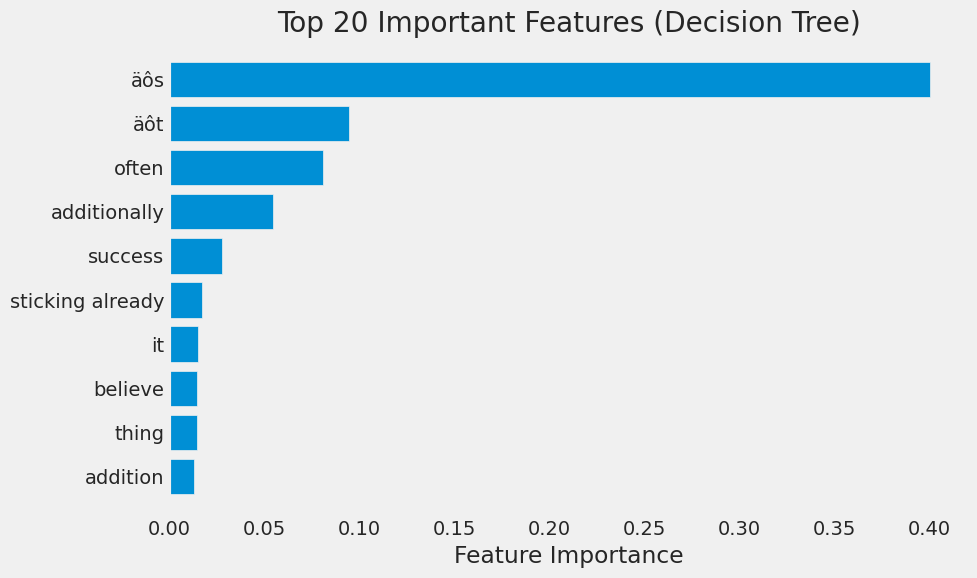

In [75]:
tree_model = pipe_tree_final.named_steps['classifier']
feature_names = pipe_tree_final.named_steps['vectorizer'].get_feature_names_out()

importances = tree_model.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 20 Important Features (Decision Tree)')
plt.grid()
plt.tight_layout()
plt.show()

Identify and analyze misclassified examples

In [94]:
print("==========SVM Misclassified Example==========")
svm_misclassified_idx = np.where(y_val != y_pred_svm)[0]
svm_misclassified_df = pd.DataFrame({
    'Original Essay': X_val.iloc[svm_misclassified_idx],
    'True Label': y_val.iloc[svm_misclassified_idx].values,
    'Predicted Label': y_pred_svm[svm_misclassified_idx]
})
svm_misclassified_df.head(10)



# #create data frame for details
# misclassified_df = pd.DataFrame({
#     'cleaned_essay': X_val,
#     'label': y_val,
#     'svm_predicted label': y_score_svm,
#     'tree_predicted label': y_score_tree
# })

# misclassified_df.head(10)

==========SVM Misclassified Example==========


Original Essay  True Label  \
37    nation becomes interesting advance faster popu...           0   
8     true today people tend give birth older previo...           0   
201   often said influential tv entertainment progra...           0   
2187  planning new town believe important build publ...           1   
2922  opinion successful people willing try new thin...           1   
216   whether parent fully intervene childrens organ...           0   
343   many country around world young people decide ...           0   
3530  many different kind people world lot found suc...           1   
3625  wise man said knowing little everything better...           1   
1640  agree successful people tend attitude trying n...           0   

      Predicted Label  
37                  1  
8                   1  
201                 1  
2187                0  
2922                0  
216                 1  
343                 1  
3530                0  
3625                0  
1640                1

In [95]:
print("==========Decision Tree Misclassified Example==========")
tree_misclassified_idx = np.where(y_val != y_pred_tree)[0]
tree_misclassified_df = pd.DataFrame({
    'Original Essay': X_val.iloc[tree_misclassified_idx],
    'True Label': y_val.iloc[tree_misclassified_idx].values,
    'Predicted Label': y_pred_svm[tree_misclassified_idx]
})
tree_misclassified_df.head(10)

==========Decision Tree Misclassified Example==========


Original Essay  True Label  \
3008  perspective agree people take risk try new thi...           1   
510   failure nobody wish could occur secondarily un...           0   
3163  although people believe successful individual ...           1   
87    developing technology utility connection thoro...           0   
2471  recently natural resource rapidly depleting ar...           1   
2837  grow society promotes myth success whether you...           1   
385   various number country rich economic weath pet...           0   
797   people espeally ordinary people often discus w...           0   
1989  eating insect new concept several southeast as...           1   
2213  today english one widely spoken language world...           1   

      Predicted Label  
3008                1  
510                 0  
3163                1  
87                  0  
2471                1  
2837                1  
385                 0  
797                 0  
1989                1  
2213                1